
# Popularity Prediction Model Comparison

This notebook trains and compares multiple models to predict movie **popularity**.
It includes baseline, linear, ensemble, and advanced gradient-boosting models.

## Objectives
- Build a reproducible supervised regression pipeline.
- Compare simple and complex models under the same split/metrics.
- Evaluate performance with both holdout and cross-validation.
- Visualize results and interpret the best model.



## 1. Imports and Environment Checks

We import standard ML libraries and then check optional availability of:
- **XGBoost** (`xgboost`)
- **LightGBM** (`lightgbm`)

If not installed, the notebook skips those models automatically.

Additional evaluation metrics included in this version:
- `MedAE` (median absolute error)
- `MAPE` (mean absolute percentage error)
- `ExplainedVariance`
- `MaxError`


In [61]:

import time
import importlib.util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
    explained_variance_score,
    max_error,
)

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

RANDOM_STATE = 42
sns.set_theme(style='whitegrid')

HAS_XGBOOST = importlib.util.find_spec('xgboost') is not None
HAS_LIGHTGBM = importlib.util.find_spec('lightgbm') is not None

if HAS_XGBOOST:
    from xgboost import XGBRegressor
if HAS_LIGHTGBM:
    from lightgbm import LGBMRegressor

print('xgboost available:', HAS_XGBOOST)
print('lightgbm available:', HAS_LIGHTGBM)


xgboost available: True
lightgbm available: True



## 2. Load the Engineered Supervised Dataset

Input file: `../data/data_supervised_popularity.csv`
- Features: engineered pre-release variables
- Target: `popularity`


In [62]:

df = pd.read_csv('../data/data_supervised_popularity.csv')
print('Shape:', df.shape)
print('Columns:', len(df.columns))
df.head(3)


Shape: (9290, 53)
Columns: 53


,runtime,director_popularity,actor1_popularity,actor2_popularity,actor3_popularity,actor4_popularity,actor5_popularity,cast_pop_mean,cast_pop_max,release_month,...,lang_de,lang_other,is_english,revenue_missing_flag,budget_missing_flag,has_budget,log_budget,has_overview,overview_length,popularity
0,148,8.2813,12.2774,5.6445,4.5824,9.6156,4.8289,7.38976,12.2774,7.0,...,0,0,1,0,0,1,18.890684,1,280,32.8952
1,100,5.1258,2.1981,1.9780,1.8252,4.9563,2.1777,2.62706,4.9563,11.0,...,0,0,1,0,0,1,19.376192,1,286,19.8760
2,124,4.0024,9.2587,5.5278,3.4058,17.8153,4.4974,8.10100,17.8153,4.0,...,0,0,1,0,0,1,19.113828,1,372,13.7900


In [63]:
print('Top missing counts:')
print(df.isna().sum().sort_values(ascending=False).head(10))

print()
print('Target describe:')
print(df['popularity'].describe())


Top missing counts:
runtime                  0
genre_History            0
genre_Music              0
genre_Mystery            0
genre_Romance            0
genre_Science Fiction    0
genre_TV Movie           0
genre_Thriller           0
genre_War                0
genre_Western            0
dtype: int64

Target describe:
count    9290.000000
mean        5.788687
std         7.689172
min         2.414700
25%         3.885000
50%         4.501300
75%         5.628275
max       378.004500
Name: popularity, dtype: float64



## 3. Explore the Target Distribution

Popularity is typically right-skewed, so this plot helps contextualize error metrics.


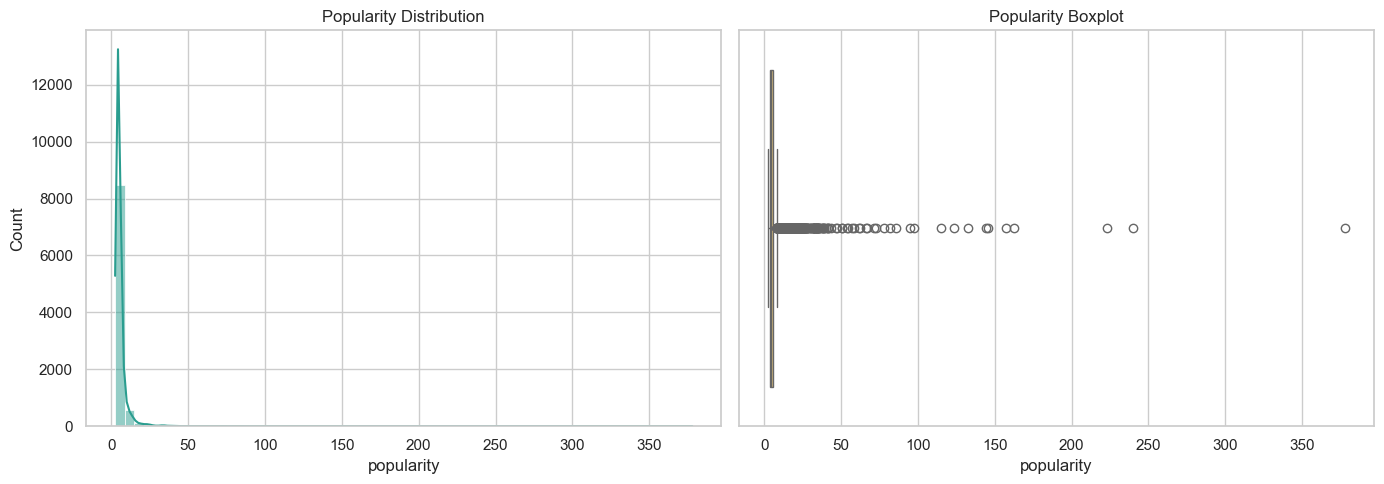

In [64]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['popularity'], bins=60, kde=True, ax=axes[0], color='#2a9d8f')
axes[0].set_title('Popularity Distribution')
axes[0].set_xlabel('popularity')

sns.boxplot(x=df['popularity'], ax=axes[1], color='#e9c46a')
axes[1].set_title('Popularity Boxplot')
axes[1].set_xlabel('popularity')

plt.tight_layout()
plt.show()



## 4. Train/Test Split

We keep 20% as a final holdout test set.


In [65]:

X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)


X_train: (7432, 52)
X_test:  (1858, 52)



## 5. Define Model Set

Models included:
- Baseline: `DummyRegressor`
- Linear: `LinearRegression`, `RidgeCV`
- Tree Ensembles: `RandomForest`, `ExtraTrees`, `GradientBoosting`, `HistGradientBoosting`
- Advanced Boosters: `XGBoost`, `LightGBM` (if installed)


In [66]:

models = {
    'Dummy Mean': Pipeline([
        ('model', DummyRegressor(strategy='mean'))
    ]),
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'RidgeCV': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RidgeCV(alphas=np.logspace(-3, 3, 13)))
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestRegressor(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    'Extra Trees': Pipeline([
        ('model', ExtraTreesRegressor(
            n_estimators=500,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    'Gradient Boosting': Pipeline([
        ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
    ]),
    'Hist Gradient Boosting': Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=RANDOM_STATE))
    ])
}

if HAS_XGBOOST:
    models['XGBoost'] = Pipeline([
        ('model', XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.85,
            colsample_bytree=0.85,
            objective='reg:squarederror',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

if HAS_LIGHTGBM:
    models['LightGBM'] = Pipeline([
        ('model', LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

print('Models to run:')
for m in models:
    print('-', m)


Models to run:
- Dummy Mean
- Linear Regression
- RidgeCV
- Random Forest
- Extra Trees
- Gradient Boosting
- Hist Gradient Boosting
- XGBoost
- LightGBM



## 6. Train, Cross-Validate, and Score

Metrics:
- **MAE**: average absolute error
- **RMSE**: penalizes larger errors
- **R2**: explained variance relative to mean baseline
- **MedAE**: robust typical absolute error
- **MAPE**: relative percentage error
- **ExplainedVariance**: variance captured by predictions
- **MaxError**: worst-case absolute error
- **CV_RMSE**: 3-fold mean RMSE on training split
- **FitTimeSec**: training time for complexity/performance tradeoff


In [67]:

results = []
fitted_models = {}
test_predictions = {}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

y_range = max(y_test.max() - y_test.min(), 1e-9)

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    exp_var = explained_variance_score(y_test, y_pred)
    mx_err = max_error(y_test, y_pred)
    nrmse = rmse / y_range

    cv_rmse = -cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    ).mean()

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MedAE': medae,
        'MAPE': mape,
        'ExplainedVariance': exp_var,
        'MaxError': mx_err,
        'NRMSE': nrmse,
        'CV_RMSE': cv_rmse,
        'FitTimeSec': fit_time
    })

    fitted_models[name] = model
    test_predictions[name] = y_pred

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)

# Rank-based composite for easier multi-metric comparison
rank_lower_better = ['MAE', 'RMSE', 'MedAE', 'MAPE', 'MaxError', 'NRMSE', 'CV_RMSE', 'FitTimeSec']
rank_higher_better = ['R2', 'ExplainedVariance']

for col in rank_lower_better:
    results_df[f'Rank_{col}'] = results_df[col].rank(method='min', ascending=True)
for col in rank_higher_better:
    results_df[f'Rank_{col}'] = results_df[col].rank(method='min', ascending=False)

rank_cols = [c for c in results_df.columns if c.startswith('Rank_')]
results_df['AvgRank'] = results_df[rank_cols].mean(axis=1)
results_df = results_df.sort_values(['RMSE', 'AvgRank']).reset_index(drop=True)

results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3146
[LightGBM] [Info] Number of data points in the train set: 7432, number of used features: 52
[LightGBM] [Info] Start training from score 5.842702
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3130
[LightGBM] [Info] Number of data points in the train set: 4955, number of used features: 52
[Li

,Model,MAE,RMSE,R2,MedAE,MAPE,ExplainedVariance,MaxError,NRMSE,CV_RMSE,...,Rank_RMSE,Rank_MedAE,Rank_MAPE,Rank_MaxError,Rank_NRMSE,Rank_CV_RMSE,Rank_FitTimeSec,Rank_R2,Rank_ExplainedVariance,AvgRank
0,XGBoost,1.626463,4.185346,0.314174,0.759325,0.256156,3.154477e-01,70.477079,0.029496,7.614286,...,1.0,2.0,1.0,3.0,1.0,5.0,6.0,1.0,1.0,2.2
1,Gradient Boosting,1.685983,4.431288,0.231204,0.771642,0.262510,2.321372e-01,70.068337,0.031229,7.699749,...,2.0,6.0,2.0,2.0,2.0,6.0,7.0,2.0,3.0,3.5
2,Random Forest,1.672186,4.439115,0.228486,0.763136,0.269342,2.328539e-01,68.982040,0.031285,7.301699,...,3.0,4.0,3.0,1.0,3.0,3.0,9.0,3.0,2.0,3.3
3,RidgeCV,2.067456,4.683050,0.141364,1.335009,0.362587,1.432700e-01,130.308302,0.033004,7.841485,...,4.0,7.0,7.0,8.0,4.0,7.0,3.0,4.0,4.0,5.5
4,Linear Regression,2.190431,4.732834,0.123012,1.460261,0.388597,1.245312e-01,129.618872,0.033355,7.849961,...,5.0,8.0,9.0,7.0,5.0,8.0,2.0,5.0,5.0,6.3
5,LightGBM,1.839230,4.756288,0.114298,0.760354,0.283805,1.144391e-01,75.015338,0.033520,7.510146,...,6.0,3.0,6.0,4.0,6.0,4.0,5.0,6.0,6.0,5.2
6,Hist Gradient Boosting,1.772528,4.800057,0.097922,0.741571,0.271376,9.961133e-02,76.260340,0.033828,7.290314,...,7.0,1.0,4.0,5.0,7.0,1.0,4.0,7.0,7.0,4.8
7,Dummy Mean,2.158683,5.061085,-0.002856,1.657452,0.370166,-2.220446e-16,138.467998,0.035668,8.206709,...,8.0,9.0,8.0,9.0,8.0,9.0,1.0,8.0,8.0,7.6
8,Extra Trees,1.690371,5.141636,-0.035032,0.768522,0.277719,-2.953899e-02,116.218597,0.036236,7.290559,...,9.0,5.0,5.0,6.0,9.0,2.0,8.0,9.0,9.0,6.6


## 7. Metrics Comparison Table and Visual Comparison

First, we create a compact table to compare all model metrics side-by-side.
Then we visualize core metrics with bar charts and a standardized heatmap.


,Model,MAE,RMSE,R2,MedAE,MAPE,ExplainedVariance,MaxError,NRMSE,CV_RMSE,FitTimeSec,AvgRank
0,XGBoost,1.626,4.185,0.3142,0.759,0.2562,0.3154,70.477,0.0295,7.614,1.122,2.20
1,Gradient Boosting,1.686,4.431,0.2312,0.772,0.2625,0.2321,70.068,0.0312,7.700,2.439,3.50
2,Random Forest,1.672,4.439,0.2285,0.763,0.2693,0.2329,68.982,0.0313,7.302,8.432,3.30
3,RidgeCV,2.067,4.683,0.1414,1.335,0.3626,0.1433,130.308,0.0330,7.841,0.357,5.50
4,Linear Regression,2.190,4.733,0.1230,1.460,0.3886,0.1245,129.619,0.0334,7.850,0.149,6.30
5,LightGBM,1.839,4.756,0.1143,0.760,0.2838,0.1144,75.015,0.0335,7.510,1.047,5.20
6,Hist Gradient Boosting,1.773,4.800,0.0979,0.742,0.2714,0.0996,76.260,0.0338,7.290,0.668,4.80
7,Dummy Mean,2.159,5.061,-0.0029,1.657,0.3702,-0.0000,138.468,0.0357,8.207,0.001,7.60
8,Extra Trees,1.690,5.142,-0.0350,0.769,0.2777,-0.0295,116.219,0.0362,7.291,4.850,6.60


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/3023679878.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='RMSE', y='Model', ax=axes[0, 0], palette='viridis')
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/3023679878.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='MAE', y='Model', ax=axes[0, 1], palette='mako')
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/3023679878.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='

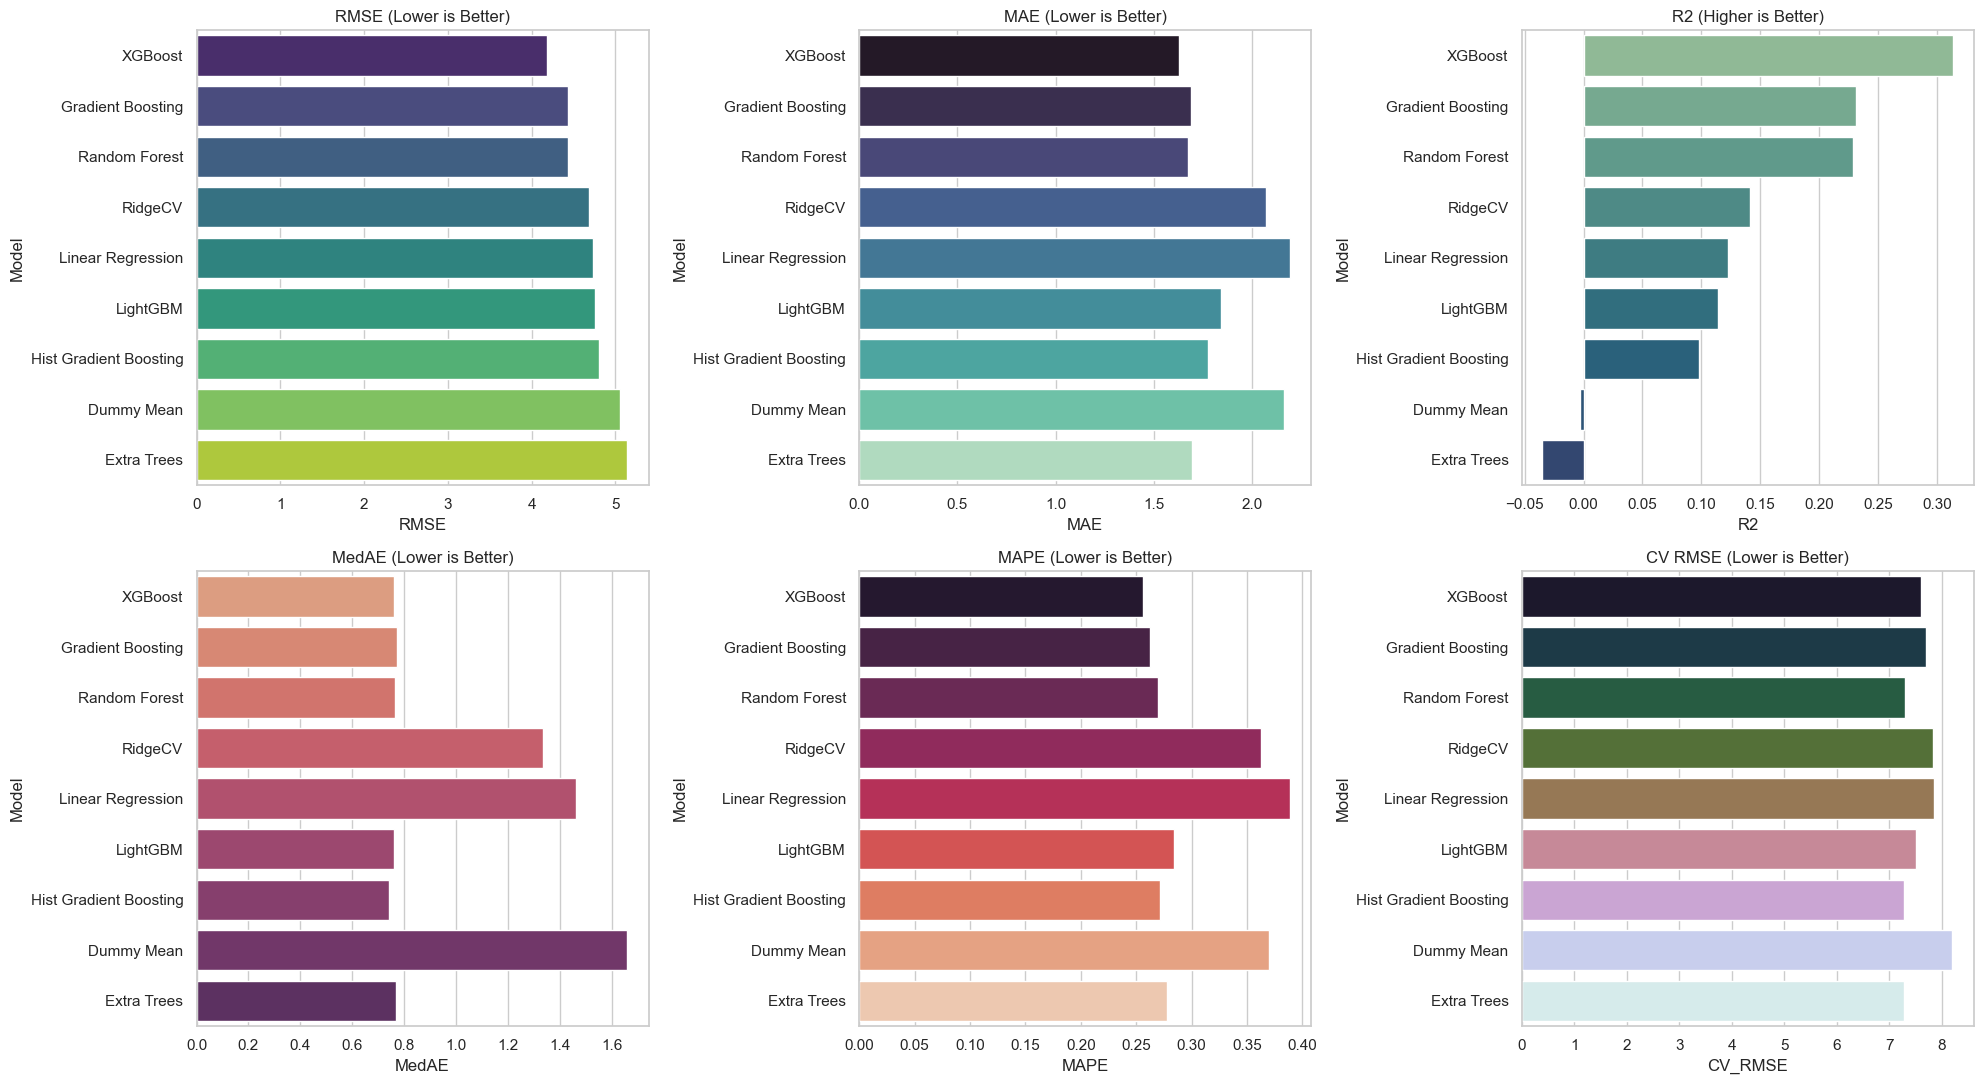

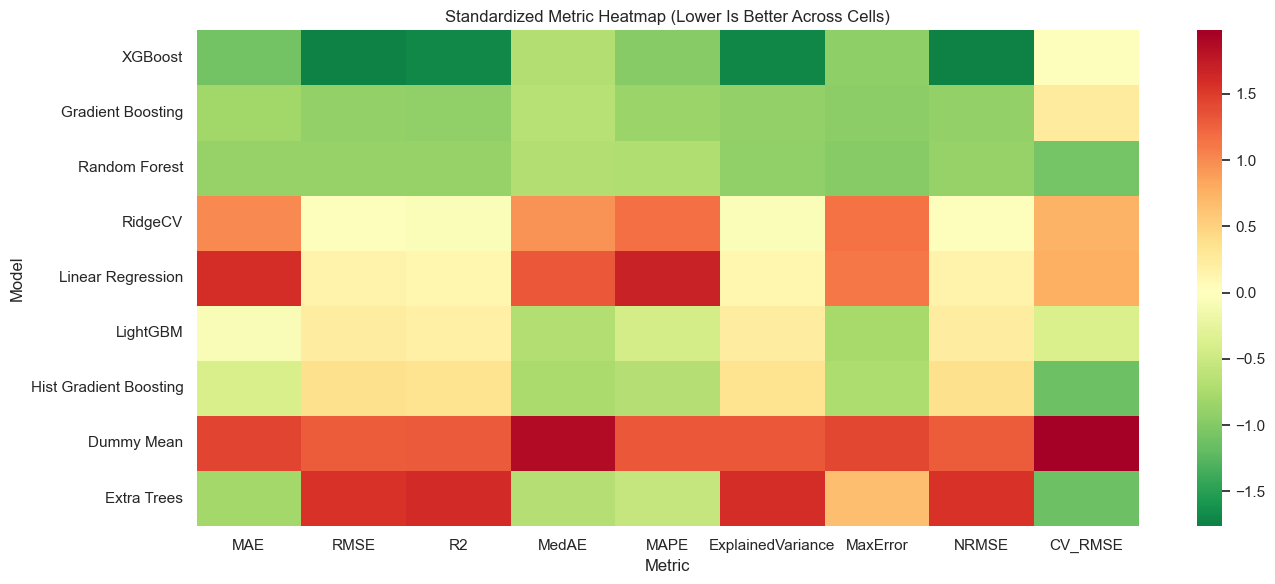

In [68]:
# Side-by-side metric comparison table for all models
metric_cols = ['MAE', 'RMSE', 'R2', 'MedAE', 'MAPE', 'ExplainedVariance', 'MaxError', 'NRMSE', 'CV_RMSE', 'FitTimeSec', 'AvgRank']
comparison_table = results_df[['Model'] + metric_cols].copy()

format_map = {
    'MAE': '{:.3f}',
    'RMSE': '{:.3f}',
    'R2': '{:.4f}',
    'MedAE': '{:.3f}',
    'MAPE': '{:.4f}',
    'ExplainedVariance': '{:.4f}',
    'MaxError': '{:.3f}',
    'NRMSE': '{:.4f}',
    'CV_RMSE': '{:.3f}',
    'FitTimeSec': '{:.3f}',
    'AvgRank': '{:.2f}'
}

display(comparison_table.style.format(format_map))

fig, axes = plt.subplots(2, 3, figsize=(20, 11))

sns.barplot(data=results_df, x='RMSE', y='Model', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE (Lower is Better)')

sns.barplot(data=results_df, x='MAE', y='Model', ax=axes[0, 1], palette='mako')
axes[0, 1].set_title('MAE (Lower is Better)')

sns.barplot(data=results_df, x='R2', y='Model', ax=axes[0, 2], palette='crest')
axes[0, 2].set_title('R2 (Higher is Better)')

sns.barplot(data=results_df, x='MedAE', y='Model', ax=axes[1, 0], palette='flare')
axes[1, 0].set_title('MedAE (Lower is Better)')

sns.barplot(data=results_df, x='MAPE', y='Model', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('MAPE (Lower is Better)')

sns.barplot(data=results_df, x='CV_RMSE', y='Model', ax=axes[1, 2], palette='cubehelix')
axes[1, 2].set_title('CV RMSE (Lower is Better)')

plt.tight_layout()
plt.show()

# Heatmap on z-scored metrics (invert higher-is-better so all cells follow lower-is-better visual convention)
heat = results_df[['Model'] + metric_cols[:-2]].set_index('Model').copy()
heat['R2'] = -heat['R2']
heat['ExplainedVariance'] = -heat['ExplainedVariance']
heat_z = (heat - heat.mean()) / heat.std(ddof=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heat_z, cmap='RdYlGn_r', center=0, annot=False)
plt.title('Standardized Metric Heatmap (Lower Is Better Across Cells)')
plt.xlabel('Metric')
plt.ylabel('Model')
plt.tight_layout()
plt.show()



## 8. Best Model Diagnostics

We pick the model with lowest holdout RMSE.
Then inspect calibration (actual vs predicted) and residual shape.


In [69]:

best_model_name = results_df.iloc[0]['Model']
best_model = fitted_models[best_model_name]
y_pred_best = test_predictions[best_model_name]
residuals = y_test - y_pred_best

print('Best model by RMSE:', best_model_name)


Best model by RMSE: XGBoost


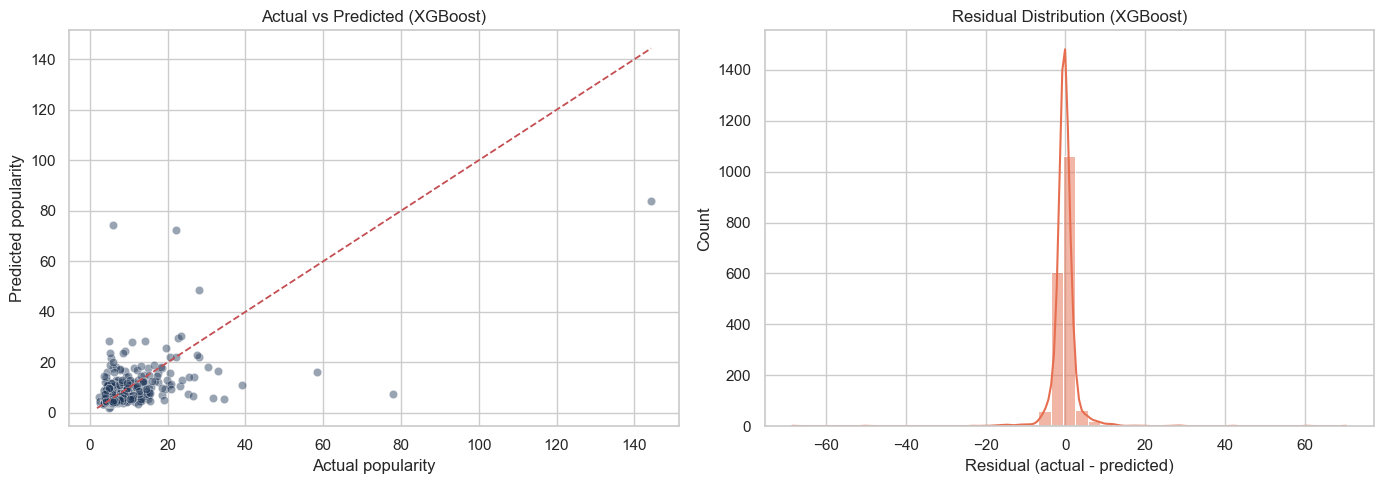

In [70]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.45, ax=axes[0], color='#1d3557')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0].plot(lims, lims, 'r--', linewidth=1.3)
axes[0].set_title(f'Actual vs Predicted ({best_model_name})')
axes[0].set_xlabel('Actual popularity')
axes[0].set_ylabel('Predicted popularity')

sns.histplot(residuals, bins=45, kde=True, ax=axes[1], color='#e76f51')
axes[1].set_title(f'Residual Distribution ({best_model_name})')
axes[1].set_xlabel('Residual (actual - predicted)')

plt.tight_layout()
plt.show()



## 9. Model Interpretation

- For tree-based models: plot top feature importances.
- For linear models: plot largest absolute coefficients.


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/1419952097.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='Blues_r')


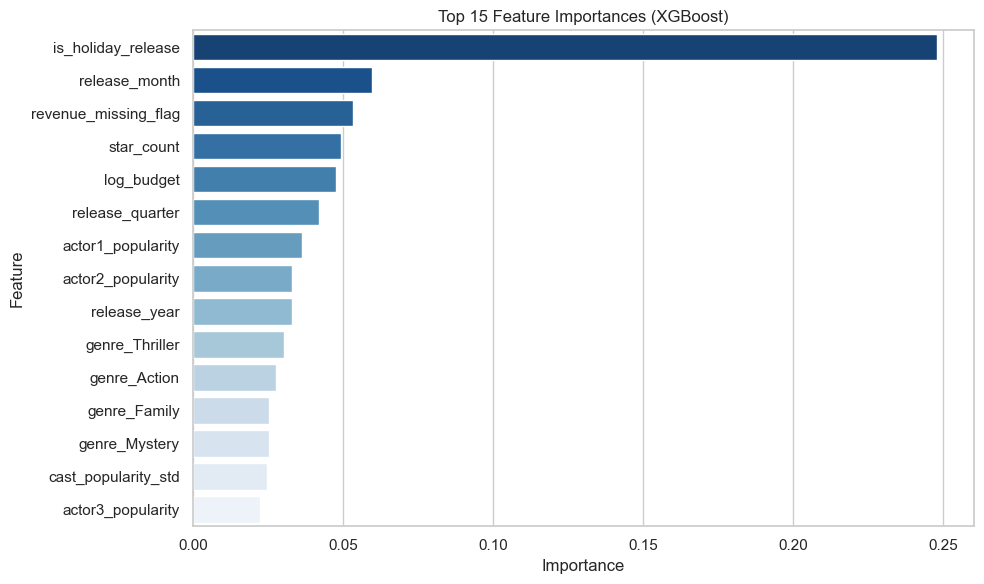

In [71]:

estimator = best_model.named_steps['model']
feature_names = X_train.columns

if hasattr(estimator, 'feature_importances_'):
    imp = pd.Series(estimator.feature_importances_, index=feature_names)
    top = imp.sort_values(ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top.values, y=top.index, palette='Blues_r')
    plt.title(f'Top 15 Feature Importances ({best_model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

elif hasattr(estimator, 'coef_'):
    coef = pd.Series(np.ravel(estimator.coef_), index=feature_names)
    top_idx = coef.abs().sort_values(ascending=False).head(15).index
    top_coef = coef.loc[top_idx].sort_values()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_coef.values, y=top_coef.index, palette='coolwarm')
    plt.title(f'Top 15 Coefficients ({best_model_name})')
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

else:
    print('No direct importances/coefficients available for this estimator.')



## 10. Summary and Next Steps

After running all cells, summarize:
1. Best model and absolute metric gains vs baseline.
2. Whether CV ranking matches holdout ranking.
3. Any sign of outlier-driven errors in residuals.
4. Next tuning steps (hyperparameter search, target transform, feature selection).


## 11. Robustness: Stronger CV + SHAP

This section adds:
- Repeated cross-validation on top holdout candidates for more stable ranking
- SHAP-based explainability for the best tree model (if `shap` is installed)


In [72]:
from sklearn.model_selection import RepeatedKFold, cross_validate

# Re-evaluate top models under repeated CV for stability (beyond single split)
TOP_N = min(3, len(results_df))
top_models = results_df['Model'].head(TOP_N).tolist()

rkfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
}

cv_rows = []
for name in top_models:
    model = models[name]
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=rkfold,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )

    rmse_vals = -scores['test_rmse']
    mae_vals = -scores['test_mae']
    r2_vals = scores['test_r2']

    cv_rows.append({
        'Model': name,
        'CV_RMSE_Mean': rmse_vals.mean(),
        'CV_RMSE_Std': rmse_vals.std(ddof=0),
        'CV_MAE_Mean': mae_vals.mean(),
        'CV_MAE_Std': mae_vals.std(ddof=0),
        'CV_R2_Mean': r2_vals.mean(),
        'CV_R2_Std': r2_vals.std(ddof=0),
    })

robust_cv_df = pd.DataFrame(cv_rows).sort_values('CV_RMSE_Mean').reset_index(drop=True)
print('Repeated CV (5x2) on top holdout models:')
display(robust_cv_df.style.format({
    'CV_RMSE_Mean': '{:.3f}', 'CV_RMSE_Std': '{:.3f}',
    'CV_MAE_Mean': '{:.3f}', 'CV_MAE_Std': '{:.3f}',
    'CV_R2_Mean': '{:.4f}', 'CV_R2_Std': '{:.4f}',
}))



Repeated CV (5x2) on top holdout models:


,Model,CV_RMSE_Mean,CV_RMSE_Std,CV_MAE_Mean,CV_MAE_Std,CV_R2_Mean,CV_R2_Std
0,Random Forest,7.165,1.898,1.842,0.153,0.1581,0.2064
1,Gradient Boosting,7.312,2.054,1.824,0.174,0.0799,0.4493
2,XGBoost,7.630,2.184,1.863,0.206,-0.0202,0.5064


SHAP summary for best model: XGBoost


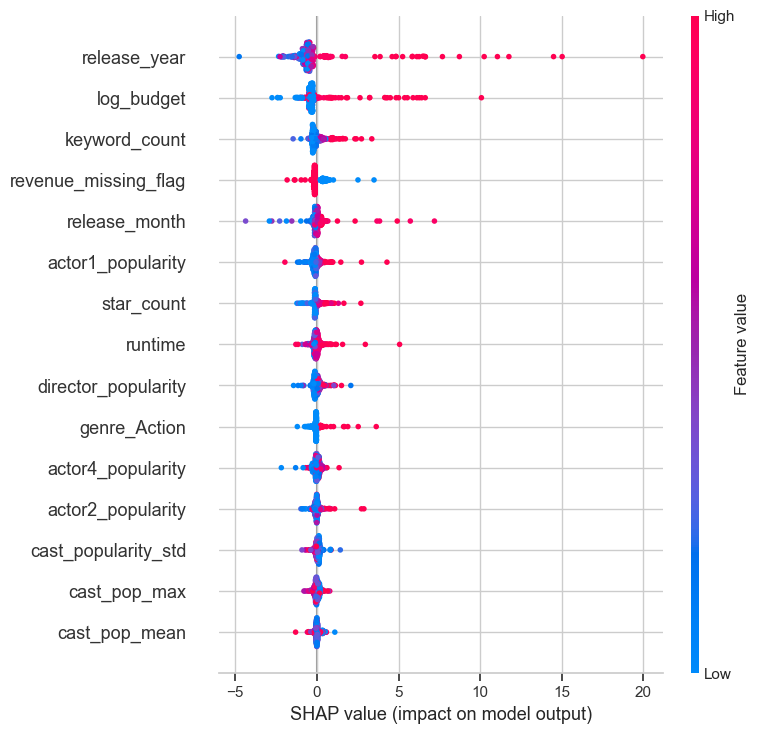

Top SHAP Features (XGBoost native contribs)


,Feature,MeanAbsSHAP
0,release_year,1.06851
1,log_budget,0.63181
2,keyword_count,0.28610
3,revenue_missing_flag,0.26253
4,release_month,0.24116
5,actor1_popularity,0.19804
6,star_count,0.17565
7,runtime,0.16781
8,director_popularity,0.16600
9,genre_Action,0.14012


In [73]:
# SHAP explainability with XGBoost-safe path + generic fallback
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

estimator = best_model.named_steps['model']

if not HAS_SHAP:
    print('SHAP not installed. Install with: pip install shap')
elif not hasattr(estimator, 'predict'):
    print('Best estimator not compatible with SHAP explainers.')
else:
    X_shap = X_train.sample(min(400, len(X_train)), random_state=RANDOM_STATE).copy()

    def _show_top_importance(values, X_ref, title='Top SHAP Features'):
        arr = np.abs(np.asarray(values))
        if arr.ndim == 3:  # multiclass
            arr = arr.mean(axis=0)
        mean_abs = arr.mean(axis=0)
        imp_df = (
            pd.DataFrame({'Feature': X_ref.columns, 'MeanAbsSHAP': mean_abs})
            .sort_values('MeanAbsSHAP', ascending=False)
            .head(15)
            .reset_index(drop=True)
        )
        print(title)
        display(imp_df.style.format({'MeanAbsSHAP': '{:.5f}'}))

    print(f'SHAP summary for best model: {best_model_name}')

    # 1) XGBoost best model: use native pred_contribs to avoid SHAP parser bug
    if best_model_name == 'XGBoost':
        try:
            import xgboost as xgb
            booster = estimator.get_booster()
            dmat = xgb.DMatrix(X_shap, feature_names=list(X_shap.columns))
            contrib = booster.predict(dmat, pred_contribs=True)  # includes bias term in last col
            shap_values = contrib[:, :-1]

            shap.summary_plot(shap_values, X_shap, max_display=15)
            _show_top_importance(shap_values, X_shap, title='Top SHAP Features (XGBoost native contribs)')

        except Exception as e:
            print(f'Native XGBoost SHAP path failed ({type(e).__name__}: {e}). Falling back to model-agnostic SHAP...')
            bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
            explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
            sv = explainer(X_shap)
            shap.plots.beeswarm(sv, max_display=15)
            _show_top_importance(sv.values, X_shap, title='Top SHAP Features (agnostic fallback)')

    # 2) Other tree models
    elif best_model_name in ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'Hist Gradient Boosting', 'LightGBM']:
        try:
            explainer = shap.TreeExplainer(estimator)
            shap_values = explainer.shap_values(X_shap)
            shap.summary_plot(shap_values, X_shap, max_display=15)
            _show_top_importance(shap_values, X_shap)
        except Exception as e:
            print(f'TreeExplainer failed ({type(e).__name__}: {e}). Using model-agnostic SHAP fallback...')
            bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
            explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
            sv = explainer(X_shap)
            shap.plots.beeswarm(sv, max_display=15)
            _show_top_importance(sv.values, X_shap, title='Top SHAP Features (agnostic fallback)')

    # 3) Linear/other models
    else:
        bg = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE).copy()
        explainer = shap.Explainer(lambda X: estimator.predict(pd.DataFrame(X, columns=X_shap.columns)), bg)
        sv = explainer(X_shap)
        shap.plots.beeswarm(sv, max_display=15)
        _show_top_importance(sv.values, X_shap)



## 12. Causal Inference (Observational, Approximate)

We estimate the effect of budget availability (`has_budget`) on popularity using:
- IPW (Inverse Probability Weighting)
- Doubly Robust (AIPW-style residualized estimator)

This is **not** a randomized experiment; interpret as sensitivity analysis under strong assumptions (no unobserved confounding).


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Treatment = has_budget (1 vs 0)


,Estimator,Estimate (popularity points),StdErr (DR only),95% CI Low (DR only),95% CI High (DR only)
0,IPW ATE,0.403,nan,nan,nan
1,Doubly Robust ATE,0.721,0.224,0.282,1.161


Propensity score range: [0.004, 0.999]
Treated share: 0.295


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/1361233187.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_df, x='T', y='ps', palette=['#e76f51', '#2a9d8f'], ax=axes[0, 1])
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_26398/1361233187.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Control (0)', 'Treated (1)'])


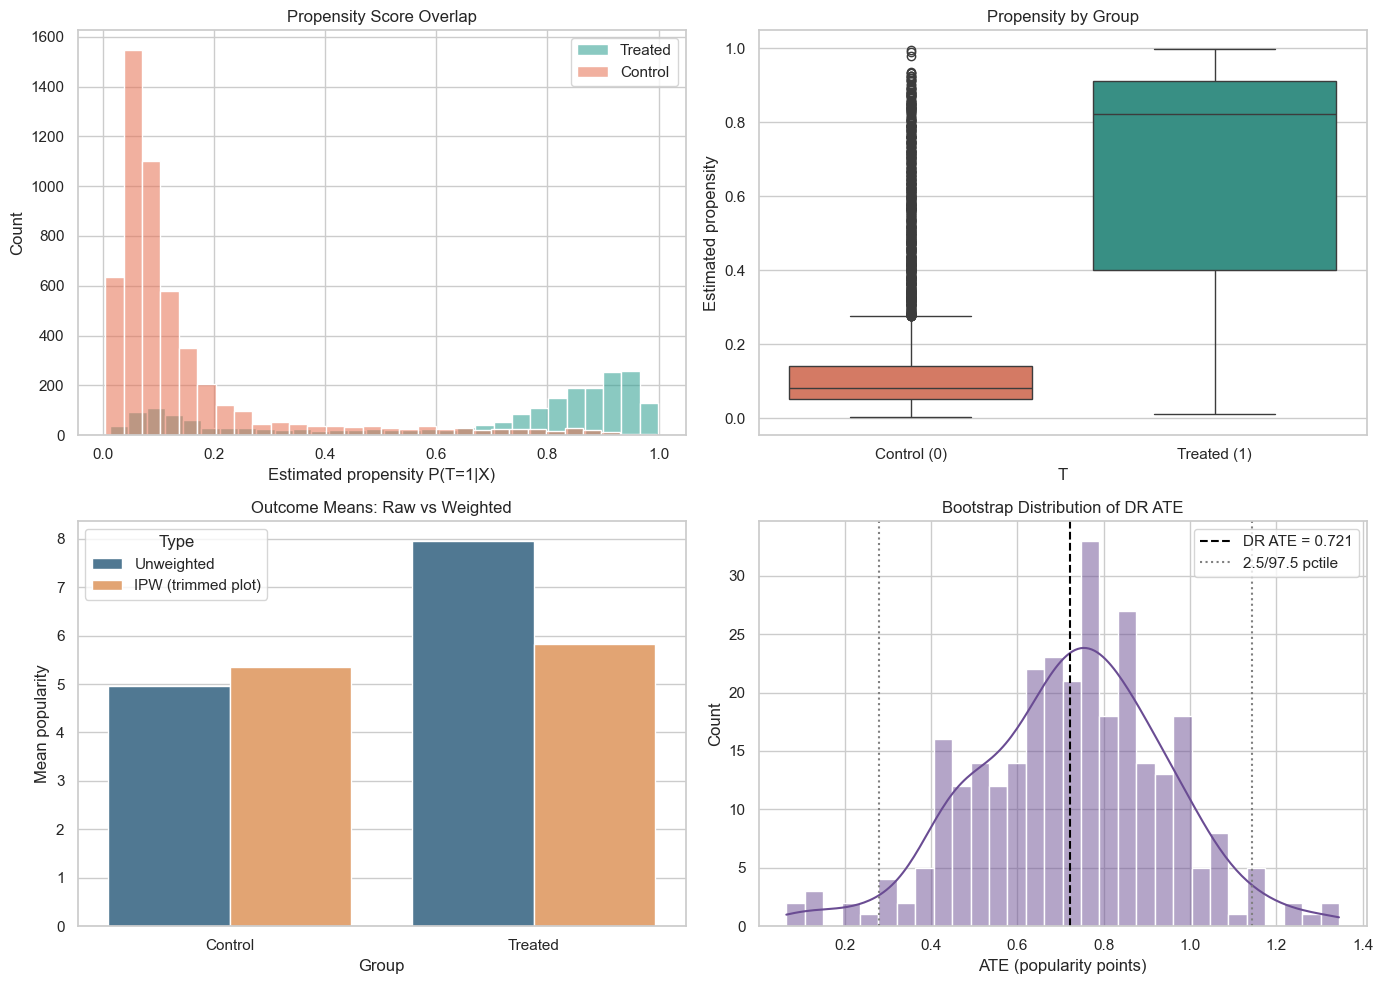

In [74]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Use training split to avoid peeking at test labels for this exploratory causal analysis
causal_df = X_train.copy()
causal_df = causal_df.assign(popularity=y_train.values)

if 'has_budget' not in causal_df.columns:
    print('Causal analysis skipped: has_budget not in feature set.')
else:
    T = causal_df['has_budget'].astype(int).values
    Y = causal_df['popularity'].values

    # Confounders: exclude treatment and direct treatment proxies
    drop_cols = {'has_budget', 'budget_missing_flag', 'log_budget', 'popularity'}
    conf_cols = [c for c in causal_df.columns if c not in drop_cols]
    Xc = causal_df[conf_cols].copy()

    # 1) Propensity model P(T=1|X)
    p_model = LogisticRegression(max_iter=2000)
    p_model.fit(Xc, T)
    ps = p_model.predict_proba(Xc)[:, 1]
    eps = 1e-3
    ps = np.clip(ps, eps, 1 - eps)

    # 2) Outcome models E[Y|T=1,X] and E[Y|T=0,X]
    y1_model = LinearRegression().fit(Xc[T == 1], Y[T == 1])
    y0_model = LinearRegression().fit(Xc[T == 0], Y[T == 0])

    mu1 = y1_model.predict(Xc)
    mu0 = y0_model.predict(Xc)

    # IPW ATE
    ipw_ate = np.mean((T * Y / ps) - ((1 - T) * Y / (1 - ps)))

    # Doubly robust (AIPW) ATE
    dr_scores = (mu1 - mu0) + T * (Y - mu1) / ps - (1 - T) * (Y - mu0) / (1 - ps)
    dr_ate = float(np.mean(dr_scores))
    dr_se = float(np.std(dr_scores, ddof=1) / np.sqrt(len(dr_scores)))
    dr_ci_low = dr_ate - 1.96 * dr_se
    dr_ci_high = dr_ate + 1.96 * dr_se

    out = pd.DataFrame({
        'Estimator': ['IPW ATE', 'Doubly Robust ATE'],
        'Estimate (popularity points)': [ipw_ate, dr_ate],
        'StdErr (DR only)': [np.nan, dr_se],
        '95% CI Low (DR only)': [np.nan, dr_ci_low],
        '95% CI High (DR only)': [np.nan, dr_ci_high],
    })

    print('Treatment = has_budget (1 vs 0)')
    display(out.style.format({
        'Estimate (popularity points)': '{:.3f}',
        'StdErr (DR only)': '{:.3f}',
        '95% CI Low (DR only)': '{:.3f}',
        '95% CI High (DR only)': '{:.3f}',
    }))

    print(f'Propensity score range: [{ps.min():.3f}, {ps.max():.3f}]')
    print(f'Treated share: {T.mean():.3f}')

    # -----------------------------
    # Visual diagnostics
    # -----------------------------
    viz_df = pd.DataFrame({
        'T': T,
        'Y': Y,
        'ps': ps,
        'w_ipw': np.where(T == 1, 1 / ps, 1 / (1 - ps))
    })

    # Trim extremely large weights for stable plotting only
    w_cap = np.quantile(viz_df['w_ipw'], 0.99)
    viz_df['w_plot'] = np.clip(viz_df['w_ipw'], 0, w_cap)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # (1) Propensity overlap by treatment
    sns.histplot(data=viz_df[viz_df['T'] == 1], x='ps', bins=30, alpha=0.55, color='#2a9d8f', ax=axes[0, 0], label='Treated')
    sns.histplot(data=viz_df[viz_df['T'] == 0], x='ps', bins=30, alpha=0.55, color='#e76f51', ax=axes[0, 0], label='Control')
    axes[0, 0].set_title('Propensity Score Overlap')
    axes[0, 0].set_xlabel('Estimated propensity P(T=1|X)')
    axes[0, 0].legend()

    # (2) Boxplot of propensity by treatment
    sns.boxplot(data=viz_df, x='T', y='ps', palette=['#e76f51', '#2a9d8f'], ax=axes[0, 1])
    axes[0, 1].set_xticklabels(['Control (0)', 'Treated (1)'])
    axes[0, 1].set_title('Propensity by Group')
    axes[0, 1].set_ylabel('Estimated propensity')

    # (3) Unweighted vs weighted mean outcome comparison
    unweighted_means = viz_df.groupby('T')['Y'].mean()
    weighted_treated = np.average(viz_df.loc[viz_df['T'] == 1, 'Y'], weights=viz_df.loc[viz_df['T'] == 1, 'w_plot'])
    weighted_control = np.average(viz_df.loc[viz_df['T'] == 0, 'Y'], weights=viz_df.loc[viz_df['T'] == 0, 'w_plot'])
    cmp = pd.DataFrame({
        'Group': ['Control', 'Treated', 'Control', 'Treated'],
        'Mean Y': [unweighted_means.loc[0], unweighted_means.loc[1], weighted_control, weighted_treated],
        'Type': ['Unweighted', 'Unweighted', 'IPW (trimmed plot)', 'IPW (trimmed plot)']
    })
    sns.barplot(data=cmp, x='Group', y='Mean Y', hue='Type', palette=['#457b9d', '#f4a261'], ax=axes[1, 0])
    axes[1, 0].set_title('Outcome Means: Raw vs Weighted')
    axes[1, 0].set_ylabel('Mean popularity')

    # (4) Bootstrap distribution of DR ATE
    rng = np.random.default_rng(42)
    B = 300
    dr_boot = []
    n = len(dr_scores)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        dr_boot.append(np.mean(dr_scores[idx]))
    dr_boot = np.array(dr_boot)

    sns.histplot(dr_boot, bins=30, kde=True, color='#6a4c93', ax=axes[1, 1])
    axes[1, 1].axvline(dr_ate, color='black', linestyle='--', label=f'DR ATE = {dr_ate:.3f}')
    axes[1, 1].axvline(np.percentile(dr_boot, 2.5), color='gray', linestyle=':', label='2.5/97.5 pctile')
    axes[1, 1].axvline(np.percentile(dr_boot, 97.5), color='gray', linestyle=':')
    axes[1, 1].set_title('Bootstrap Distribution of DR ATE')
    axes[1, 1].set_xlabel('ATE (popularity points)')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

